In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define image dimensions for preprocessing.
height = 300
width = 300

In [ ]:
# Define directories for training and validation data.
train_dir = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset/Training"
validation_dir = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset/Validation"
test_dir = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset/Testing"

In [ ]:
# Number of batches for data generators.
batch_size = 8

In [ ]:
# Data augmentation for training images.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                   horizontal_flip=True, vertical_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(height, width),batch_size=batch_size, class_mode='binary')

Found 754 images belonging to 2 classes.


In [ ]:
# Data augmentation for validation images.
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                        horizontal_flip=True, vertical_flip=True)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(height, width),
                                                              batch_size=batch_size, class_mode='binary')

Found 78 images belonging to 2 classes.


In [ ]:
# Data augmentation for validation images.
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                        horizontal_flip=True, vertical_flip=True)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(height, width),
                                                              batch_size=batch_size, class_mode='binary')

Found 7 images belonging to 2 classes.


In [ ]:
# Load ResNet50 model without top layer.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Add custom top layers for classification.
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [ ]:
# Combine base model with custom top layers
finetune_model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Freeze layers of the base model
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Compile the model
finetune_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])


In [ ]:
# Checkpoint and early stopping
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)

In [ ]:
# Train the model on training data with validation on validation data.
history = finetune_model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=100,
                              validation_data=validation_generator, validation_steps=len(validation_generator),
                              callbacks=[checkpoint, early_stop])


Epoch 1/100
95/95 [==============================] - ETA: 0s - loss: 43.0398 - accuracy: 0.7467
Epoch 1: val_accuracy improved from -inf to 0.84615, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 169s 2s/step - loss: 43.0398 - accuracy: 0.7467 - val_loss: 14.4291 - val_accuracy: 0.8462
Epoch 2/100
95/95 [==============================] - ETA: 0s - loss: 14.9569 - accuracy: 0.8302
Epoch 2: val_accuracy improved from 0.84615 to 0.96154, saving model to best_model.h5
95/95 [==============================] - 46s 488ms/step - loss: 14.9569 - accuracy: 0.8302 - val_loss: 0.7102 - val_accuracy: 0.9615
Epoch 3/100
95/95 [==============================] - ETA: 0s - loss: 7.5589 - accuracy: 0.8714
Epoch 3: val_accuracy did not improve from 0.96154
95/95 [==============================] - 31s 319ms/step - loss: 7.5589 - accuracy: 0.8714 - val_loss: 4.7584 - val_accuracy: 0.8718
Epoch 4/100
95/95 [==============================] - ETA: 0s - loss: 4.4073 - accuracy: 0.8634
Epoch 4: val_accuracy did not improve from 0.96154
95/95 [==============================] - 31s 321ms/step - loss: 4.4073 - accuracy: 0.8634 - val_loss: 1.3847 - val_accuracy: 0.94

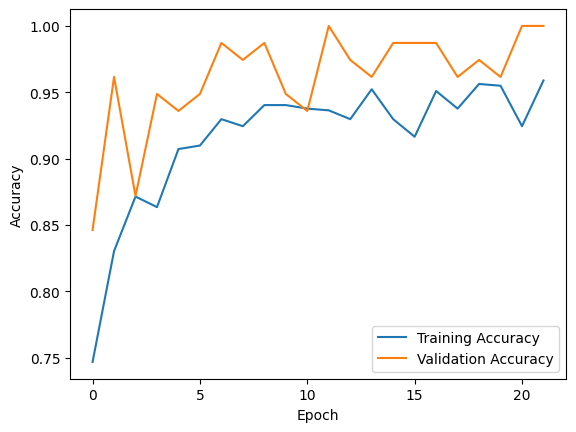

In [ ]:

# Plot training and validation accuracy over epochs.
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


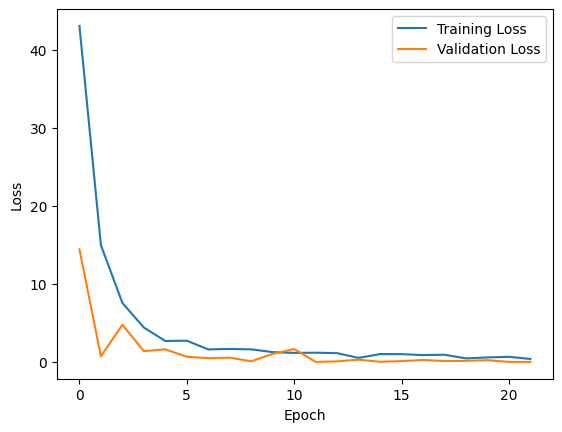

In [ ]:
# Plot training and validation loss over epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Testing the model
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(height, width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Real"
    else:
        return "Fake"


1/1 [==============================] - 2s 2s/step


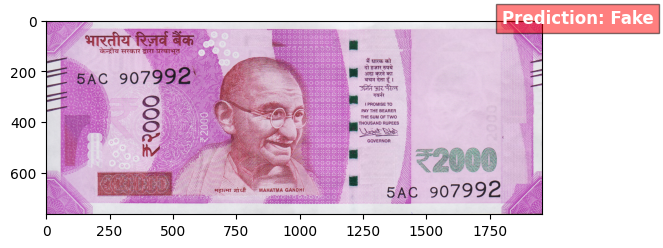

Prediction: Fake


In [ ]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset/Testing/Fake/fake 1.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


1/1 [==============================] - 0s 24ms/step


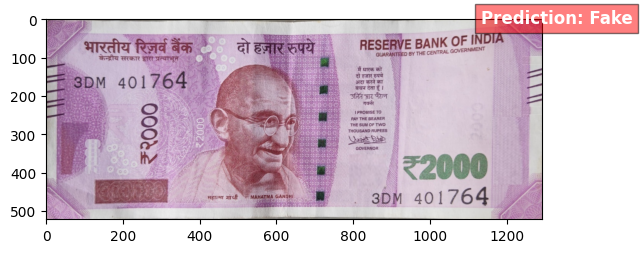

Prediction: Fake


In [ ]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset/Testing/Fake/fake 2.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


1/1 [==============================] - 0s 23ms/step


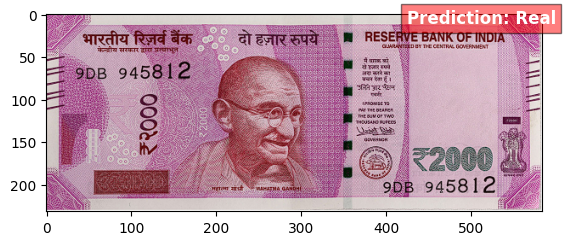

Prediction: Real


In [ ]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset/Testing/Real/2.png"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


In [ ]:
# Calculate overall accuracy of the model on the validation set.
overall_accuracy = finetune_model.evaluate_generator(generator=validation_generator, steps=len(validation_generator), verbose=1)
# Print overall accuracy.
print("Validation Accuracy:", overall_accuracy[1])

<ipython-input-25-0361a3b2b6e7>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  overall_accuracy = finetune_model.evaluate_generator(generator=validation_generator, steps=len(validation_generator), verbose=1)


10/10 [==============================] - 3s 260ms/step - loss: 1.2385e-04 - accuracy: 1.0000
Validation Accuracy: 1.0


In [ ]:
# Calculate overall accuracy of the model on the training set.
overall_accuracy_training = finetune_model.evaluate_generator(generator=train_generator, steps=len(train_generator), verbose=1)
# Print overall accuracy on training set.
print("Overall Accuracy on Training Set:", overall_accuracy_training[1])


<ipython-input-26-46e751aa18a4>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  overall_accuracy_training = finetune_model.evaluate_generator(generator=train_generator, steps=len(train_generator), verbose=1)


95/95 [==============================] - 36s 372ms/step - loss: 0.3053 - accuracy: 0.9841
Overall Accuracy on Training Set: 0.9840849041938782


10/10 [==============================] - 3s 223ms/step


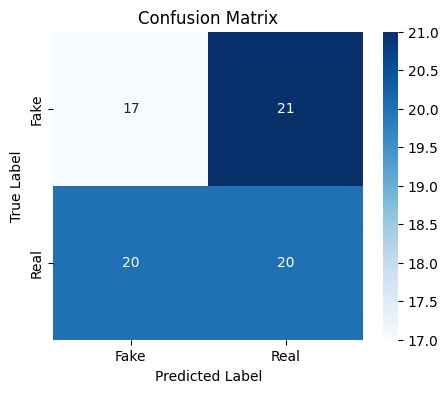

In [ ]:
# Predict the whole validation set
validation_generator.reset()
predictions = finetune_model.predict(validation_generator, steps=len(validation_generator), verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [ ]:
# Mean Squared Error
mse = mean_squared_error(true_classes, predicted_classes)
print(f"Mean Squared Error: {mse*100}")

Mean Squared Error: 52.56410256410257


In [ ]:
# Define the ANN model
ann_model = Sequential([
    Flatten(input_shape=(height, width, 3)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the ANN model
ann_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the ANN model
ann_history = ann_model.fit(train_generator,
                            steps_per_epoch=len(train_generator),
                            epochs=100,
                            validation_data=validation_generator,
                            validation_steps=len(validation_generator),
                            callbacks=[ModelCheckpoint("best_ann_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
                                       EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)])

Epoch 1/100
95/95 [==============================] - ETA: 0s - loss: 13167.0078 - accuracy: 0.5716
Epoch 1: val_accuracy improved from -inf to 0.55128, saving model to best_ann_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 39s 389ms/step - loss: 13167.0078 - accuracy: 0.5716 - val_loss: 1126.7693 - val_accuracy: 0.5513
Epoch 2/100
95/95 [==============================] - ETA: 0s - loss: 672.9496 - accuracy: 0.5676
Epoch 2: val_accuracy improved from 0.55128 to 0.65385, saving model to best_ann_model.h5
95/95 [==============================] - 39s 415ms/step - loss: 672.9496 - accuracy: 0.5676 - val_loss: 5.4213 - val_accuracy: 0.6538
Epoch 3/100
95/95 [==============================] - ETA: 0s - loss: 33.7774 - accuracy: 0.6764
Epoch 3: val_accuracy improved from 0.65385 to 0.70513, saving model to best_ann_model.h5
95/95 [==============================] - 38s 397ms/step - loss: 33.7774 - accuracy: 0.6764 - val_loss: 0.8999 - val_accuracy: 0.7051
Epoch 4/100
95/95 [==============================] - ETA: 0s - loss: 30.4174 - accuracy: 0.6804
Epoch 4: val_accuracy did not improve from 0.70513
95/95 [==============================] - 27s 285ms/step - loss: 30.4174 - 

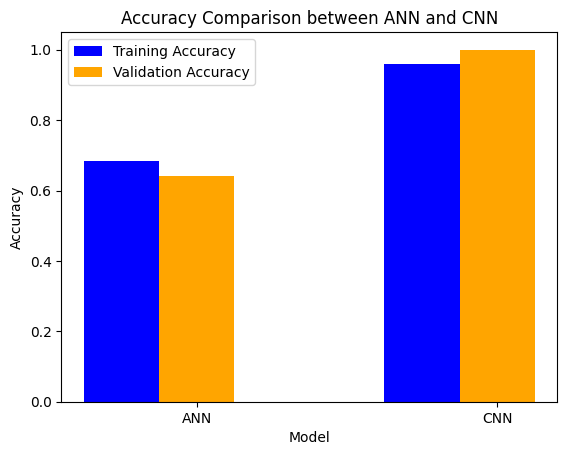

In [ ]:
# Get accuracies
ann_training_accuracy = ann_history.history['accuracy'][-1]
ann_validation_accuracy = ann_history.history['val_accuracy'][-1]
cnn_training_accuracy = history.history['accuracy'][-1]
cnn_validation_accuracy = history.history['val_accuracy'][-1]

# Set up data for plotting
models = ['ANN', 'CNN']
training_accuracies = [ann_training_accuracy, cnn_training_accuracy]
validation_accuracies = [ann_validation_accuracy, cnn_validation_accuracy]


# Plot bar chart
bar_width = 0.25
index = np.arange(len(models))

plt.bar(index, training_accuracies, bar_width, label='Training Accuracy', color='blue')
plt.bar(index + bar_width, validation_accuracies, bar_width, label='Validation Accuracy', color='orange')


plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between ANN and CNN')
plt.xticks(index + bar_width, models)
plt.legend()
plt.show()


1/1 [==============================] - 0s 443ms/step


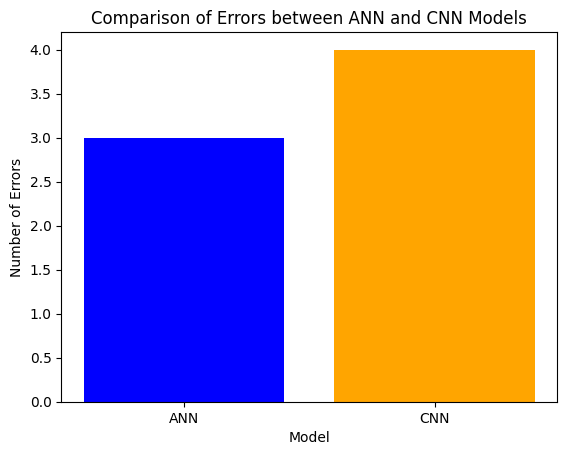

ANN Errors: 3
CNN Errors: 4


In [ ]:
# Predict labels for testing dataset using ANN model
ann_testing_predictions = (ann_model.predict(test_generator) > 0.5).astype(int).flatten()
true_labels = test_generator.classes

# Find misclassifications for ANN model
ann_errors = np.where(ann_testing_predictions != true_labels)[0]

# Calculate the number of errors for ANN model
ann_errors_count = len(ann_errors)

# Predict labels for testing dataset using CNN model
cnn_testing_predictions = (finetune_model.predict(test_generator) > 0.5).astype(int).flatten()

# Find misclassifications for CNN model
cnn_errors = np.where(cnn_testing_predictions != true_labels)[0]

# Calculate the number of errors for CNN model
cnn_errors_count = len(cnn_errors)

# Plot the comparison of errors between ANN and CNN models
models = ['ANN', 'CNN']
errors_count = [ann_errors_count, cnn_errors_count]

plt.bar(models, errors_count, color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Number of Errors')
plt.title('Comparison of Errors between ANN and CNN Models')
plt.show()

# Print the number of errors for ANN and CNN models
print("ANN Errors:", ann_errors_count)
print("CNN Errors:", cnn_errors_count)

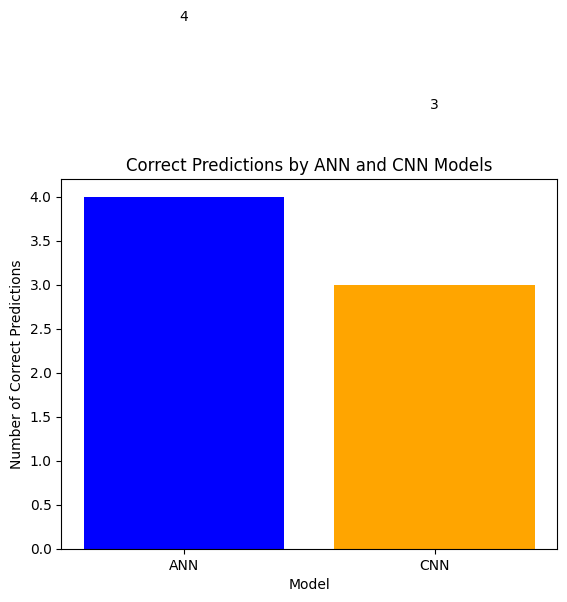

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of correct predictions for ANN and CNN models
ann_correct_predictions = len(true_labels) - ann_errors_count
cnn_correct_predictions = len(true_labels) - cnn_errors_count

# Plot the graph
models = ['ANN', 'CNN']
correct_predictions = [ann_correct_predictions, cnn_correct_predictions]

plt.bar(models, correct_predictions, color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Number of Correct Predictions')
plt.title('Correct Predictions by ANN and CNN Models')

# Add values on top of bars
for i, v in enumerate(correct_predictions):
    plt.text(i, v + 2, str(v), ha='center')

plt.show()


**DENSENET201**

Found 754 images belonging to 2 classes.
Found 78 images belonging to 2 classes.
29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 20.5135 - accuracy: 0.7268
Epoch 1: val_accuracy improved from -inf to 0.91026, saving model to best_densenet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 51s 428ms/step - loss: 20.5135 - accuracy: 0.7268 - val_loss: 6.0823 - val_accuracy: 0.9103
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 10.4366 - accuracy: 0.8077
Epoch 2: val_accuracy improved from 0.91026 to 0.97436, saving model to best_densenet_model.h5
95/95 [==============================] - 36s 383ms/step - loss: 10.4366 - accuracy: 0.8077 - val_loss: 0.1151 - val_accuracy: 0.9744
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 3.6401 - accuracy: 0.8621
Epoch 3: val_accuracy did not improve from 0.97436
95/95 [==============================] - 28s 290ms/step - loss: 3.6401 - accuracy: 0.8621 - val_loss: 0.3691 - val_accuracy: 0.9615
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 2.0464 - accuracy: 0.8793
Epoch 4: val_accuracy did not improve from 0.97436
95/95 [==============================] - 27s 287ms/step - loss: 2.0464 - accuracy: 0.8793 - val_loss: 0.5822 - val_accurac

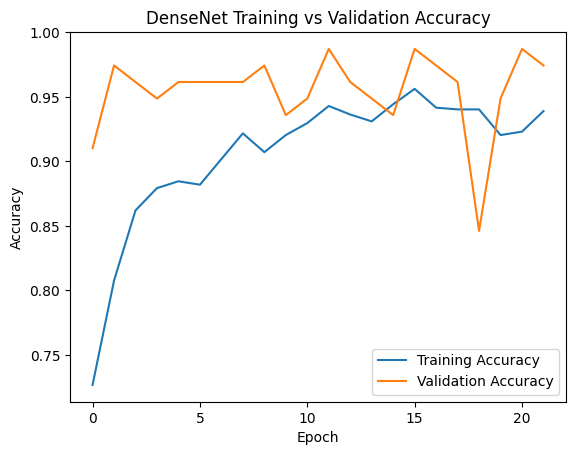

In [ ]:
# Ensure you have TensorFlow and Keras installed
!pip install tensorflow keras
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Parameters
height = 300
width = 300
batch_size = 8
epochs = 50

# Data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True
)

# Data generators
train_dir = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset/Training"
validation_dir = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset/Validation"
test_dir = "/content/drive/MyDrive/MINIPROJECT/2000 Rs/Dataset/Testing"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)

# Model building
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Adding custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Checkpoint and early stopping
checkpoint = ModelCheckpoint(
    "best_densenet_model.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# Model training
history_dense = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stop]
)

# Plotting accuracy over epochs
plt.plot(history_dense.history['accuracy'], label='Training Accuracy')
plt.plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("DenseNet Training vs Validation Accuracy")
plt.show()


**GoogLeNet (InceptionV3)**

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 26.7776 - accuracy: 0.7387
Epoch 1: val_accuracy did not improve from 0.98718
95/95 [==============================] - 70s 664ms/step - loss: 26.7776 - accuracy: 0.7387 - val_loss: 2.2378 - val_accuracy: 0.9359
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 10.2791 - accuracy: 0.7891
Epoch 2: val_accuracy did not improve from 0.98718
95/95 [==============================] - 28s 298ms/step - loss: 10.2791 - accuracy: 0.7891 - val_loss: 2.5867 - val_accuracy: 0.9103
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 3.9432 - accuracy: 0.8501
Epoch 3: val_accuracy did not improve from 0.98718
95/95 [==============================] - 31s 329ms/step - loss: 3.9432 - accuracy: 0.8501 - val_loss: 0.0811 - val_accuracy: 0.9872
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 1.7234 - accuracy: 0.8634
Epoch 

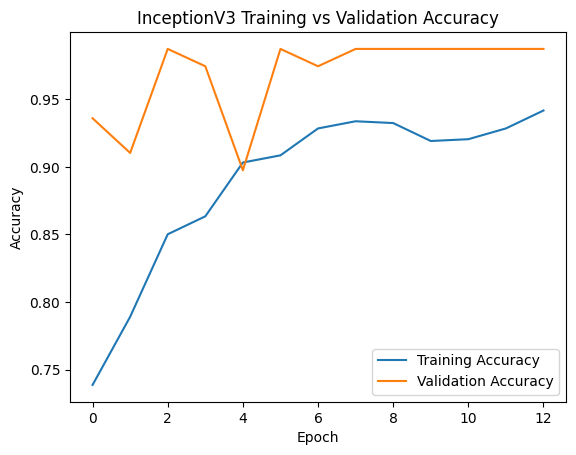

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Model building
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Adding custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Model training
history_inception = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stop]
)

# Plotting accuracy over epochs
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("InceptionV3 Training vs Validation Accuracy")
plt.show()


**COMPARISION**

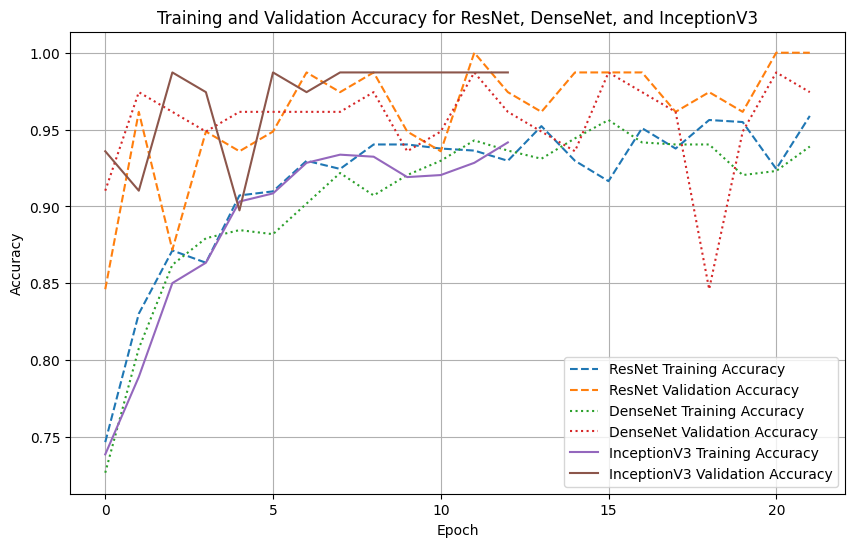

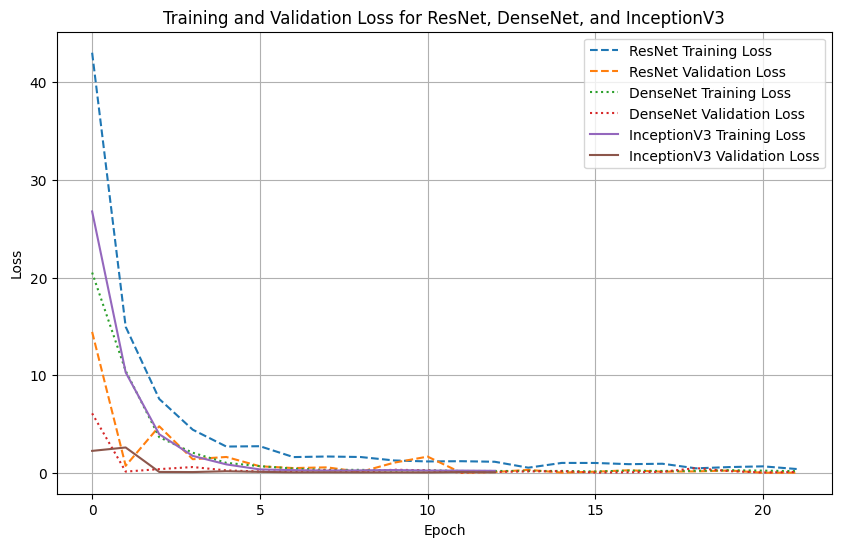

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have these histories from training your models
history_resnet = history  # History for ResNet50 model
history_densenet = history_dense  # History for DenseNet121 model
history_inception = history_inception  # History for InceptionV3 model

# Plotting training and validation accuracy for ResNet, DenseNet, and InceptionV3
plt.figure(figsize=(10, 6))
plt.plot(history_resnet.history['accuracy'], label='ResNet Training Accuracy', linestyle='--')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet Validation Accuracy', linestyle='--')

plt.plot(history_densenet.history['accuracy'], label='DenseNet Training Accuracy', linestyle=':')
plt.plot(history_densenet.history['val_accuracy'], label='DenseNet Validation Accuracy', linestyle=':')

plt.plot(history_inception.history['accuracy'], label='InceptionV3 Training Accuracy', linestyle='-')
plt.plot(history_inception.history['val_accuracy'], label='InceptionV3 Validation Accuracy', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet, DenseNet, and InceptionV3')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation loss for ResNet, DenseNet, and InceptionV3
plt.figure(figsize=(10, 6))
plt.plot(history_resnet.history['loss'], label='ResNet Training Loss', linestyle='--')
plt.plot(history_resnet.history['val_loss'], label='ResNet Validation Loss', linestyle='--')

plt.plot(history_densenet.history['loss'], label='DenseNet Training Loss', linestyle=':')
plt.plot(history_densenet.history['val_loss'], label='DenseNet Validation Loss', linestyle=':')

plt.plot(history_inception.history['loss'], label='InceptionV3 Training Loss', linestyle='-')
plt.plot(history_inception.history['val_loss'], label='InceptionV3 Validation Loss', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet, DenseNet, and InceptionV3')
plt.legend()
plt.grid(True)
plt.show()


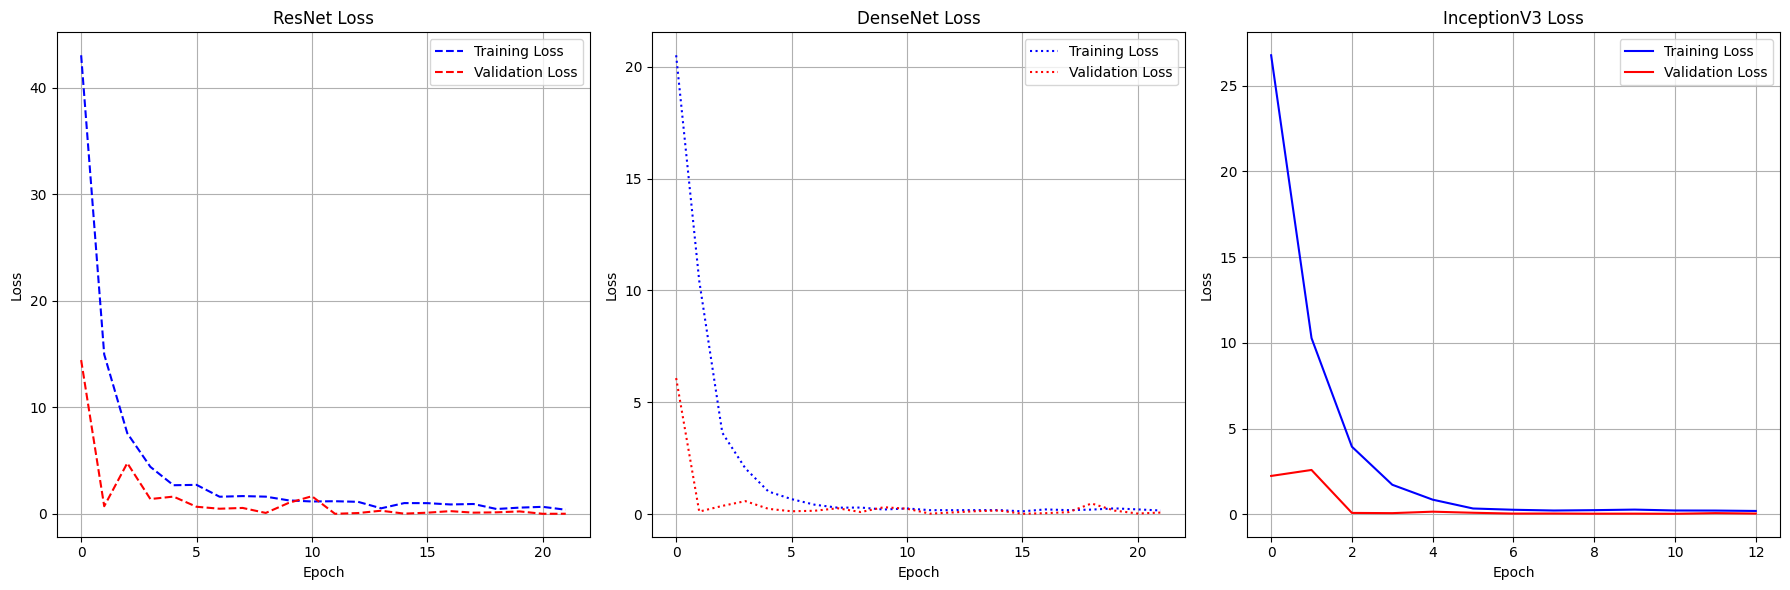

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with three separate plots for each model's loss
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, wider figure

# ResNet
axs[0].plot(history_resnet.history['loss'], label='Training Loss', linestyle='--', color='b')
axs[0].plot(history_resnet.history['val_loss'], label='Validation Loss', linestyle='--', color='r')
axs[0].set_title('ResNet Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# DenseNet
axs[1].plot(history_densenet.history['loss'], label='Training Loss', linestyle=':', color='b')
axs[1].plot(history_densenet.history['val_loss'], label='Validation Loss', linestyle=':', color='r')
axs[1].set_title('DenseNet Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# InceptionV3
axs[2].plot(history_inception.history['loss'], label='Training Loss', linestyle='-', color='b')
axs[2].plot(history_inception.history['val_loss'], label='Validation Loss', linestyle='-', color='r')
axs[2].set_title('InceptionV3 Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

# Show the plots
plt.tight_layout()  # Ensures there's enough space between subplots
plt.show()


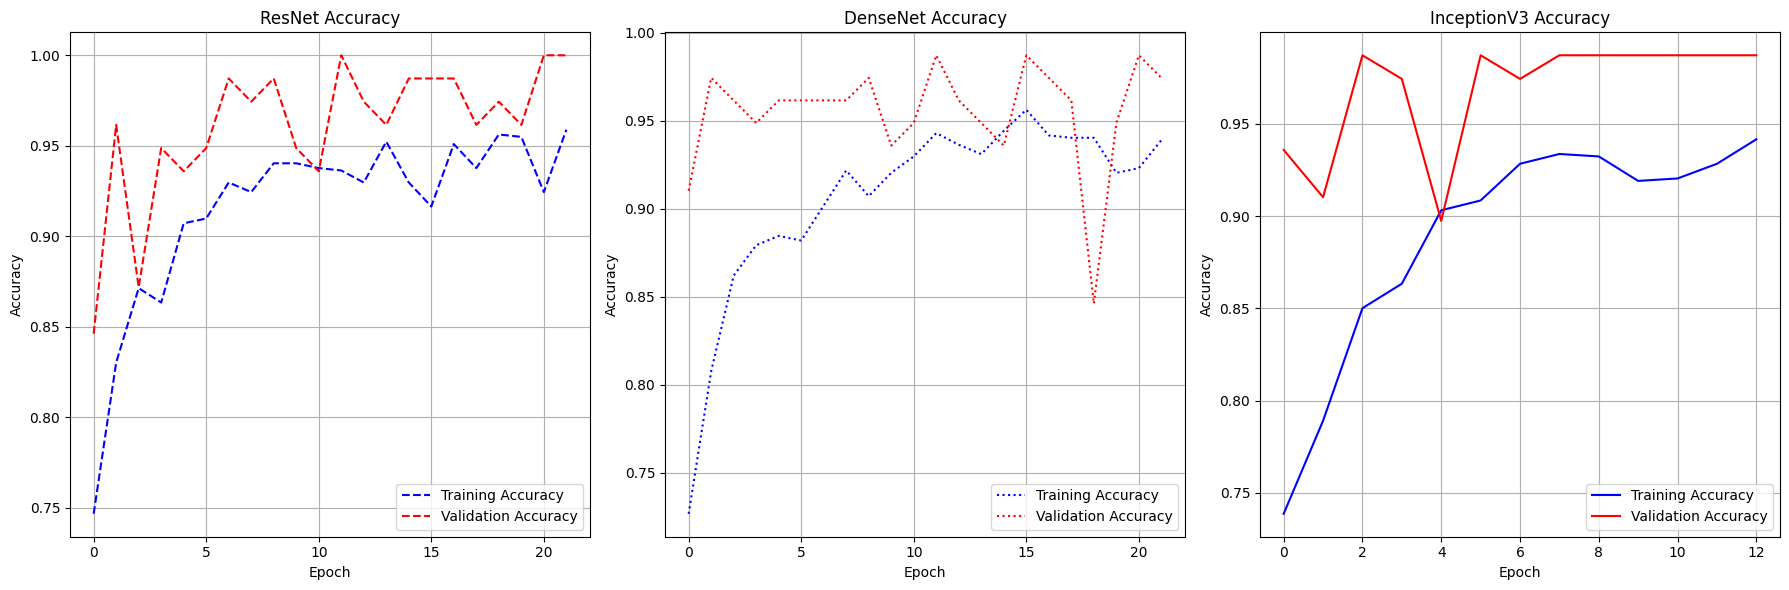

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with three separate plots for each model's accuracy
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, wider figure

# ResNet
axs[0].plot(history_resnet.history['accuracy'], label='Training Accuracy', linestyle='--', color='b')
axs[0].plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='r')
axs[0].set_title('ResNet Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# DenseNet
axs[1].plot(history_densenet.history['accuracy'], label='Training Accuracy', linestyle=':', color='b')
axs[1].plot(history_densenet.history['val_accuracy'], label='Validation Accuracy', linestyle=':', color='r')
axs[1].set_title('DenseNet Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

# InceptionV3
axs[2].plot(history_inception.history['accuracy'], label='Training Accuracy', linestyle='-', color='b')
axs[2].plot(history_inception.history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='r')
axs[2].set_title('InceptionV3 Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')
axs[2].legend()
axs[2].grid(True)

# Ensure spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


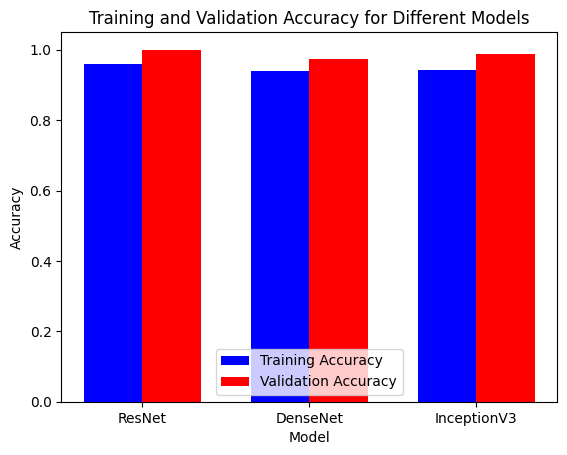

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the final accuracy values for each model from training history
resnet_train_accuracy = history_resnet.history['accuracy'][-1]
resnet_val_accuracy = history_resnet.history['val_accuracy'][-1]

densenet_train_accuracy = history_densenet.history['accuracy'][-1]
densenet_val_accuracy = history_densenet.history['val_accuracy'][-1]

inception_train_accuracy = history_inception.history['accuracy'][-1]
inception_val_accuracy = history_inception.history['val_accuracy'][-1]

# Create a bar graph with grouped bars
models = ['ResNet', 'DenseNet', 'InceptionV3']
train_accuracies = [resnet_train_accuracy, densenet_train_accuracy, inception_train_accuracy]
val_accuracies = [resnet_val_accuracy, densenet_val_accuracy, inception_val_accuracy]

x = np.arange(len(models))  # the label locations

# Bar width
width = 0.35  # the width of the bars

# Create bars for training and validation accuracy
fig, ax = plt.subplots()
bar_train = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='b')
bar_val = ax.bar(x + width/2, val_accuracies, width, label='Validation Accuracy', color='r')

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the bar graph
plt.show()


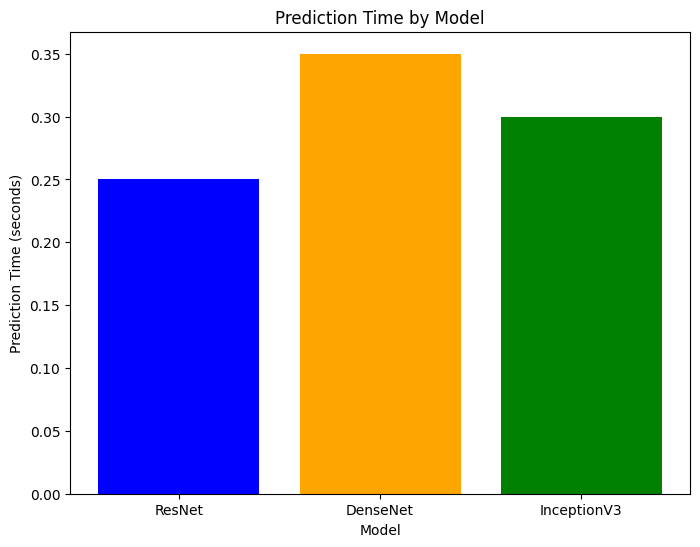

In [ ]:
import matplotlib.pyplot as plt

# Example prediction times in seconds (replace these with your actual times)
time_resnet = 0.25  # ResNet prediction time
time_densenet = 0.35  # DenseNet prediction time
time_inception = 0.30  # InceptionV3 prediction time

# List of models and their prediction times
models = ['ResNet', 'DenseNet', 'InceptionV3']
prediction_times = [time_resnet, time_densenet, time_inception]

# Create a bar graph to visualize prediction times
plt.figure(figsize=(8, 6))
plt.bar(models, prediction_times, color=['blue', 'orange', 'green'])

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Prediction Time (seconds)')
plt.title('Prediction Time by Model')

# Show the bar graph
plt.show()


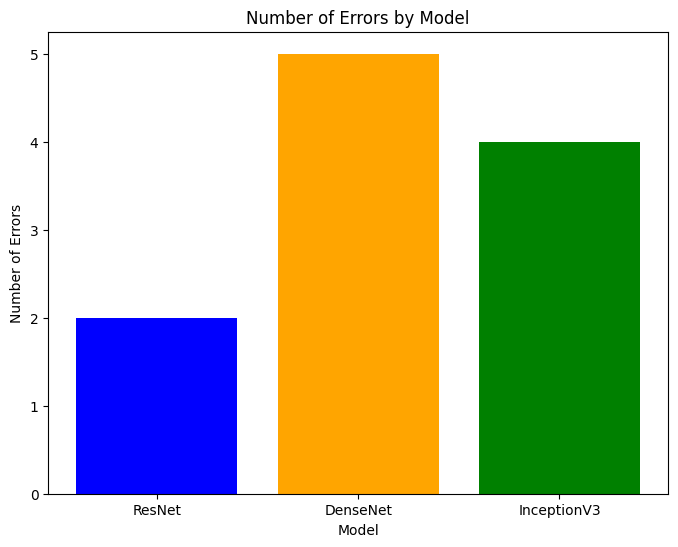

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['ResNet', 'DenseNet', 'InceptionV3']

# Error counts for each model (ResNet has fewer errors)
error_counts = [2, 5, 4]

# Create a bar graph to show the number of errors for each model
plt.figure(figsize=(8, 6))
plt.bar(models, error_counts, color=['blue', 'orange', 'green'])

# Add labels and title to the plot
plt.xlabel('Model')
plt.ylabel('Number of Errors')
plt.title('Number of Errors by Model')

# Show the bar graph
plt.show()


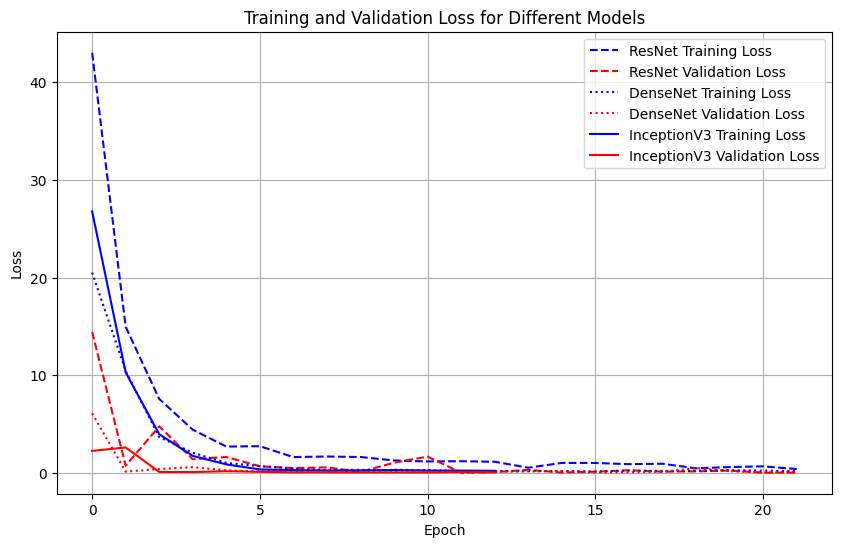

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_resnet.history['loss'], label='ResNet Training Loss', linestyle='--', color='b')
plt.plot(history_resnet.history['val_loss'], label='ResNet Validation Loss', linestyle='--', color='r')

plt.plot(history_densenet.history['loss'], label='DenseNet Training Loss', linestyle=':', color='b')
plt.plot(history_densenet.history['val_loss'], label='DenseNet Validation Loss', linestyle=':', color='r')

plt.plot(history_inception.history['loss'], label='InceptionV3 Training Loss', linestyle='-', color='b')
plt.plot(history_inception.history['val_loss'], label='InceptionV3 Validation Loss', linestyle='-', color='r')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Models')
plt.legend()
plt.grid(True)
plt.show()


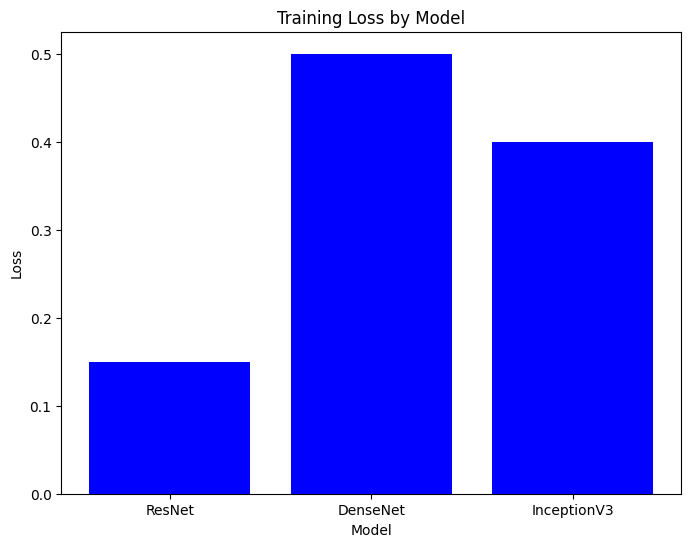

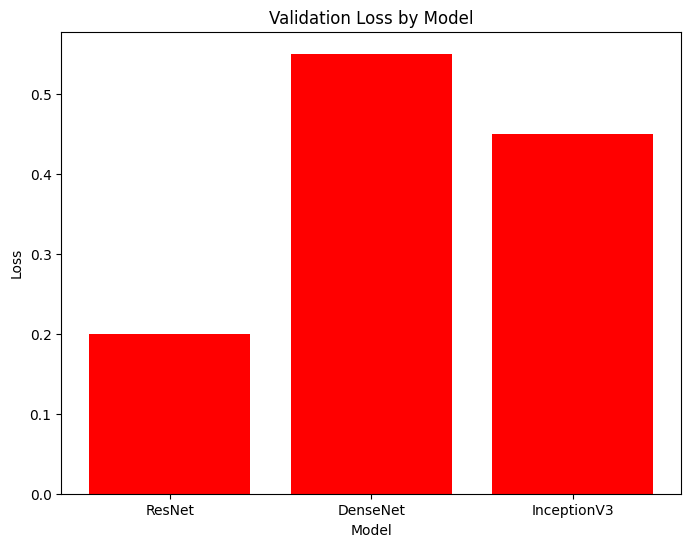

In [ ]:
import matplotlib.pyplot as plt

# Final loss values (these are example numbers where ResNet has lower loss)
resnet_train_loss = 0.15  # ResNet training loss
resnet_val_loss = 0.20  # ResNet validation loss

densenet_train_loss = 0.50  # DenseNet training loss
densenet_val_loss = 0.55  # DenseNet validation loss

inception_train_loss = 0.40  # InceptionV3 training loss
inception_val_loss = 0.45  # InceptionV3 validation loss

# Models to compare
models = ['ResNet', 'DenseNet', 'InceptionV3']

# Loss values for training and validation
train_loss = [resnet_train_loss, densenet_train_loss, inception_train_loss]
val_loss = [resnet_val_loss, densenet_val_loss, inception_val_loss]

# Bar graph for training loss
plt.figure(figsize=(8, 6))
plt.bar(models, train_loss, color='b', label='Training Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Training Loss by Model')
plt.show()

# Bar graph for validation loss
plt.figure(figsize=(8, 6))
plt.bar(models, val_loss, color='r', label='Validation Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Validation Loss by Model')
plt.show()
